In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
def load_image_paths(base_path):
    data = []
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            frame_paths = [
                os.path.join(folder_path, f"frame{i}.jpg") for i in [1, 2, 3]
            ]
            if all(os.path.exists(p) for p in frame_paths):
                data.append(frame_paths)
    return pd.DataFrame(data, columns=['frame1', 'frame2', 'frame3'])
def load_image_paths2(base_path):
    data = []
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            frame_paths = [
                os.path.join(folder_path, f"frame{i}.png") for i in [1, 2, 3]
            ]
            if all(os.path.exists(p) for p in frame_paths):
                data.append(frame_paths)
    return pd.DataFrame(data, columns=['frame1', 'frame2', 'frame3'])

In [3]:
trainDataLoc=load_image_paths("/kaggle/input/atd-12-dataset/datasets/train_10k")
testDataLoc=load_image_paths("/kaggle/input/atd-12-dataset/datasets/test_2k_original")


In [4]:
train2=load_image_paths2("/kaggle/input/atd-12-dataset/datasets/test_2k_540p")

In [5]:
trainDataLoc=pd.concat([trainDataLoc,train2])

In [6]:
trainDataLoc.shape

(12000, 3)

In [7]:
trainDataLoc.iloc[3].frame1

'/kaggle/input/atd-12-dataset/datasets/train_10k/Japan_3_120443_s3/frame1.jpg'

In [8]:
trainDataLoc.iloc[0:3]

,frame1,frame2,frame3
0,/kaggle/input/atd-12-dataset/datasets/train_10...,/kaggle/input/atd-12-dataset/datasets/train_10...,/kaggle/input/atd-12-dataset/datasets/train_10...
1,/kaggle/input/atd-12-dataset/datasets/train_10...,/kaggle/input/atd-12-dataset/datasets/train_10...,/kaggle/input/atd-12-dataset/datasets/train_10...
2,/kaggle/input/atd-12-dataset/datasets/train_10...,/kaggle/input/atd-12-dataset/datasets/train_10...,/kaggle/input/atd-12-dataset/datasets/train_10...


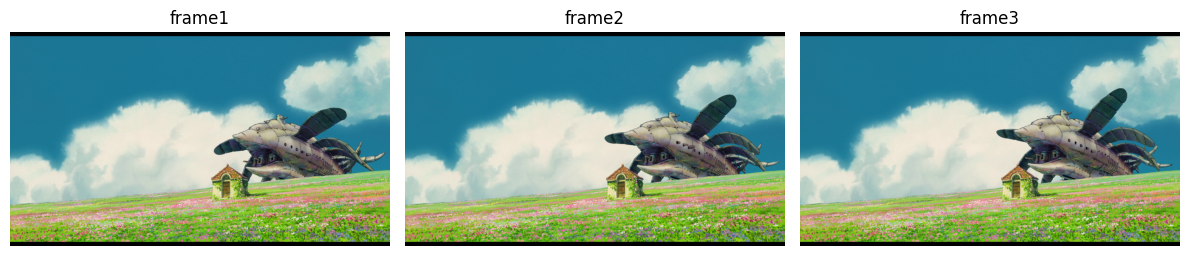

In [9]:
def showimages(row):
    plt.figure(figsize=(12,4))
    for i,frame_col in enumerate(['frame1','frame2','frame3']):
        img_path=row[frame_col]
        img=Image.open(img_path)
        plt.subplot(1,3,i+1)
        plt.imshow(img)
        plt.title(frame_col)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
showimages(trainDataLoc.iloc[3])

In [10]:
import torch
import torch.nn as nn

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backwarp_tenGrid = {}


def warp(tenInput, tenFlow):
    k = (str(tenFlow.device), str(tenFlow.size()))
    if k not in backwarp_tenGrid:
        tenHorizontal = torch.linspace(-1.0, 1.0, tenFlow.shape[3], device=device).view(
            1, 1, 1, tenFlow.shape[3]).expand(tenFlow.shape[0], -1, tenFlow.shape[2], -1)
        tenVertical = torch.linspace(-1.0, 1.0, tenFlow.shape[2], device=device).view(
            1, 1, tenFlow.shape[2], 1).expand(tenFlow.shape[0], -1, -1, tenFlow.shape[3])
        backwarp_tenGrid[k] = torch.cat(
            [tenHorizontal, tenVertical], 1).to(device)

    tenFlow = torch.cat([tenFlow[:, 0:1, :, :] / ((tenInput.shape[3] - 1.0) / 2.0),
                         tenFlow[:, 1:2, :, :] / ((tenInput.shape[2] - 1.0) / 2.0)], 1)

    g = (backwarp_tenGrid[k] + tenFlow).permute(0, 2, 3, 1)
    return torch.nn.functional.grid_sample(input=tenInput, grid=g, mode='bilinear', padding_mode='border', align_corners=True)

In [11]:
# refine
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import itertools
# from model.warplayer import warp
import torch.nn.functional as F

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def conv(in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                  padding=padding, dilation=dilation, bias=True),
        nn.PReLU(out_planes)
        )

def deconv(in_planes, out_planes, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        torch.nn.ConvTranspose2d(in_channels=in_planes, out_channels=out_planes, kernel_size=4, stride=2, padding=1, bias=True),
        nn.PReLU(out_planes)
        )
            
class Conv2(nn.Module):
    def __init__(self, in_planes, out_planes, stride=2):
        super(Conv2, self).__init__()
        self.conv1 = conv(in_planes, out_planes, 3, stride, 1)
        self.conv2 = conv(out_planes, out_planes, 3, 1, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x
    
c = 16
class Contextnet(nn.Module):
    def __init__(self):
        super(Contextnet, self).__init__()
        self.conv1 = Conv2(3, c)
        self.conv2 = Conv2(c, 2*c)
        self.conv3 = Conv2(2*c, 4*c)
        self.conv4 = Conv2(4*c, 8*c)
    
    def forward(self, x, flow):
        x = self.conv1(x)
        flow = F.interpolate(flow, scale_factor=0.5, mode="bilinear", align_corners=False, recompute_scale_factor=False) * 0.5
        f1 = warp(x, flow)        
        x = self.conv2(x)
        flow = F.interpolate(flow, scale_factor=0.5, mode="bilinear", align_corners=False, recompute_scale_factor=False) * 0.5
        f2 = warp(x, flow)
        x = self.conv3(x)
        flow = F.interpolate(flow, scale_factor=0.5, mode="bilinear", align_corners=False, recompute_scale_factor=False) * 0.5
        f3 = warp(x, flow)
        x = self.conv4(x)
        flow = F.interpolate(flow, scale_factor=0.5, mode="bilinear", align_corners=False, recompute_scale_factor=False) * 0.5
        f4 = warp(x, flow)
        return [f1, f2, f3, f4]
    
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.down0 = Conv2(17, 2*c)
        self.down1 = Conv2(4*c, 4*c)
        self.down2 = Conv2(8*c, 8*c)
        self.down3 = Conv2(16*c, 16*c)
        self.up0 = deconv(32*c, 8*c)
        self.up1 = deconv(16*c, 4*c)
        self.up2 = deconv(8*c, 2*c)
        self.up3 = deconv(4*c, c)
        self.conv = nn.Conv2d(c, 3, 3, 1, 1)

    def forward(self, img0, img1, warped_img0, warped_img1, mask, flow, c0, c1):
        s0 = self.down0(torch.cat((img0, img1, warped_img0, warped_img1, mask, flow), 1))
        s1 = self.down1(torch.cat((s0, c0[0], c1[0]), 1))
        s2 = self.down2(torch.cat((s1, c0[1], c1[1]), 1))
        s3 = self.down3(torch.cat((s2, c0[2], c1[2]), 1))
        x = self.up0(torch.cat((s3, c0[3], c1[3]), 1))
        x = self.up1(torch.cat((x, s2), 1)) 
        x = self.up2(torch.cat((x, s1), 1)) 
        x = self.up3(torch.cat((x, s0), 1)) 
        x = self.conv(x)
        return torch.sigmoid(x)


In [12]:
# IFNET
import torch
import torch.nn as nn
import torch.nn.functional as F
# from model.warplayer import warp
# from model.refine import *

def deconv(in_planes, out_planes, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        torch.nn.ConvTranspose2d(in_channels=in_planes, out_channels=out_planes, kernel_size=4, stride=2, padding=1),
        nn.PReLU(out_planes)
    )

def conv(in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                  padding=padding, dilation=dilation, bias=True),
        nn.PReLU(out_planes)
    )

class IFBlock(nn.Module):
    def __init__(self, in_planes, c=64):
        super(IFBlock, self).__init__()
        self.conv0 = nn.Sequential(
            conv(in_planes, c//2, 3, 2, 1),
            conv(c//2, c, 3, 2, 1),
            )
        self.convblock = nn.Sequential(
            conv(c, c),
            conv(c, c),
            conv(c, c),
            conv(c, c),
            conv(c, c),
            conv(c, c),
            conv(c, c),
            conv(c, c),
        )
        self.lastconv = nn.ConvTranspose2d(c, 5, 4, 2, 1)

    def forward(self, x, flow, scale):
        if scale != 1:
            x = F.interpolate(x, scale_factor = 1. / scale, mode="bilinear", align_corners=False)
        if flow != None:
            flow = F.interpolate(flow, scale_factor = 1. / scale, mode="bilinear", align_corners=False) * 1. / scale
            x = torch.cat((x, flow), 1)
        x = self.conv0(x)
        x = self.convblock(x) + x
        tmp = self.lastconv(x)
        tmp = F.interpolate(tmp, scale_factor = scale * 2, mode="bilinear", align_corners=False)
        flow = tmp[:, :4] * scale * 2
        mask = tmp[:, 4:5]
        return flow, mask
    
class IFNet(nn.Module):
    def __init__(self):
        super(IFNet, self).__init__()
        self.block0 = IFBlock(6, c=240)
        self.block1 = IFBlock(13+4, c=150)
        self.block2 = IFBlock(13+4, c=90)
        self.block_tea = IFBlock(16+4, c=90)
        self.contextnet = Contextnet()
        self.unet = Unet()

    def forward(self, x, scale=[4,2,1], timestep=0.5):
        img0 = x[:, :3]
        img1 = x[:, 3:6]
        gt = x[:, 6:] # In inference time, gt is None
        flow_list = []
        merged = []
        mask_list = []
        warped_img0 = img0
        warped_img1 = img1
        flow = None 
        loss_distill = 0
        stu = [self.block0, self.block1, self.block2]
        for i in range(3):
            if flow != None:
                flow_d, mask_d = stu[i](torch.cat((img0, img1, warped_img0, warped_img1, mask), 1), flow, scale=scale[i])
                flow = flow + flow_d
                mask = mask + mask_d
            else:
                flow, mask = stu[i](torch.cat((img0, img1), 1), None, scale=scale[i])
            mask_list.append(torch.sigmoid(mask))
            flow_list.append(flow)
            warped_img0 = warp(img0, flow[:, :2])
            warped_img1 = warp(img1, flow[:, 2:4])
            merged_student = (warped_img0, warped_img1)
            merged.append(merged_student)
        if gt.shape[1] == 3:
            flow_d, mask_d = self.block_tea(torch.cat((img0, img1, warped_img0, warped_img1, mask, gt), 1), flow, scale=1)
            flow_teacher = flow + flow_d
            warped_img0_teacher = warp(img0, flow_teacher[:, :2])
            warped_img1_teacher = warp(img1, flow_teacher[:, 2:4])
            mask_teacher = torch.sigmoid(mask + mask_d)
            merged_teacher = warped_img0_teacher * mask_teacher + warped_img1_teacher * (1 - mask_teacher)
        else:
            flow_teacher = None
            merged_teacher = None
        for i in range(3):
            merged[i] = merged[i][0] * mask_list[i] + merged[i][1] * (1 - mask_list[i])
            if gt.shape[1] == 3:
                loss_mask = ((merged[i] - gt).abs().mean(1, True) > (merged_teacher - gt).abs().mean(1, True) + 0.01).float().detach()
                loss_distill += (((flow_teacher.detach() - flow_list[i]) ** 2).mean(1, True) ** 0.5 * loss_mask).mean()
        c0 = self.contextnet(img0, flow[:, :2])
        c1 = self.contextnet(img1, flow[:, 2:4])
        tmp = self.unet(img0, img1, warped_img0, warped_img1, mask, flow, c0, c1)
        res = tmp[:, :3] * 2 - 1
        merged[2] = torch.clamp(merged[2] + res, 0, 1)
        return flow_list, mask_list[2], merged, flow_teacher, merged_teacher, loss_distill

In [13]:
# IFNETM
import torch
import torch.nn as nn
import torch.nn.functional as F
# from model.warplayer import warp
# from model.refine import *

def deconv(in_planes, out_planes, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        torch.nn.ConvTranspose2d(in_channels=in_planes, out_channels=out_planes, kernel_size=4, stride=2, padding=1),
        nn.PReLU(out_planes)
    )

def conv(in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                  padding=padding, dilation=dilation, bias=True),
        nn.PReLU(out_planes)
    )

class IFBlock(nn.Module):
    def __init__(self, in_planes, c=64):
        super(IFBlock, self).__init__()
        self.conv0 = nn.Sequential(
            conv(in_planes, c//2, 3, 2, 1),
            conv(c//2, c, 3, 2, 1),
            )
        self.convblock = nn.Sequential(
            conv(c, c),
            conv(c, c),
            conv(c, c),
            conv(c, c),
            conv(c, c),
            conv(c, c),
            conv(c, c),
            conv(c, c),
        )
        self.lastconv = nn.ConvTranspose2d(c, 5, 4, 2, 1)

    def forward(self, x, flow, scale):
        if scale != 1:
            x = F.interpolate(x, scale_factor = 1. / scale, mode="bilinear", align_corners=False)
        if flow != None:
            flow = F.interpolate(flow, scale_factor = 1. / scale, mode="bilinear", align_corners=False) * 1. / scale
            x = torch.cat((x, flow), 1)
        x = self.conv0(x)
        x = self.convblock(x) + x
        tmp = self.lastconv(x)
        tmp = F.interpolate(tmp, scale_factor = scale * 2, mode="bilinear", align_corners=False)
        flow = tmp[:, :4] * scale * 2
        mask = tmp[:, 4:5]
        return flow, mask
    
class IFNet_m(nn.Module):
    def __init__(self):
        super(IFNet_m, self).__init__()
        self.block0 = IFBlock(6+1, c=240)
        self.block1 = IFBlock(13+4+1, c=150)
        self.block2 = IFBlock(13+4+1, c=90)
        self.block_tea = IFBlock(16+4+1, c=90)
        self.contextnet = Contextnet()
        self.unet = Unet()

    def forward(self, x, scale=[4,2,1], timestep=0.5, returnflow=False):
        timestep = (x[:, :1].clone() * 0 + 1) * timestep
        img0 = x[:, :3]
        img1 = x[:, 3:6]
        gt = x[:, 6:] # In inference time, gt is None
        flow_list = []
        merged = []
        mask_list = []
        warped_img0 = img0
        warped_img1 = img1
        flow = None 
        loss_distill = 0
        stu = [self.block0, self.block1, self.block2]
        for i in range(3):
            if flow != None:
                flow_d, mask_d = stu[i](torch.cat((img0, img1, timestep, warped_img0, warped_img1, mask), 1), flow, scale=scale[i])
                flow = flow + flow_d
                mask = mask + mask_d
            else:
                flow, mask = stu[i](torch.cat((img0, img1, timestep), 1), None, scale=scale[i])
            mask_list.append(torch.sigmoid(mask))
            flow_list.append(flow)
            warped_img0 = warp(img0, flow[:, :2])
            warped_img1 = warp(img1, flow[:, 2:4])
            merged_student = (warped_img0, warped_img1)
            merged.append(merged_student)
        if gt.shape[1] == 3:
            flow_d, mask_d = self.block_tea(torch.cat((img0, img1, timestep, warped_img0, warped_img1, mask, gt), 1), flow, scale=1)
            flow_teacher = flow + flow_d
            warped_img0_teacher = warp(img0, flow_teacher[:, :2])
            warped_img1_teacher = warp(img1, flow_teacher[:, 2:4])
            mask_teacher = torch.sigmoid(mask + mask_d)
            merged_teacher = warped_img0_teacher * mask_teacher + warped_img1_teacher * (1 - mask_teacher)
        else:
            flow_teacher = None
            merged_teacher = None
        for i in range(3):
            merged[i] = merged[i][0] * mask_list[i] + merged[i][1] * (1 - mask_list[i])
            if gt.shape[1] == 3:
                loss_mask = ((merged[i] - gt).abs().mean(1, True) > (merged_teacher - gt).abs().mean(1, True) + 0.01).float().detach()
                loss_distill += (((flow_teacher.detach() - flow_list[i]) ** 2).mean(1, True) ** 0.5 * loss_mask).mean()
        if returnflow:
            return flow
        else:
            c0 = self.contextnet(img0, flow[:, :2])
            c1 = self.contextnet(img1, flow[:, 2:4])
            tmp = self.unet(img0, img1, warped_img0, warped_img1, mask, flow, c0, c1)
            res = tmp[:, :3] * 2 - 1
            merged[2] = torch.clamp(merged[2] + res, 0, 1)
        return flow_list, mask_list[2], merged, flow_teacher, merged_teacher, loss_distill

In [14]:
# LOSS
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class EPE(nn.Module):
    def __init__(self):
        super(EPE, self).__init__()

    def forward(self, flow, gt, loss_mask):
        loss_map = (flow - gt.detach()) ** 2
        loss_map = (loss_map.sum(1, True) + 1e-6) ** 0.5
        return (loss_map * loss_mask)


class Ternary(nn.Module):
    def __init__(self):
        super(Ternary, self).__init__()
        patch_size = 7
        out_channels = patch_size * patch_size
        self.w = np.eye(out_channels).reshape(
            (patch_size, patch_size, 1, out_channels))
        self.w = np.transpose(self.w, (3, 2, 0, 1))
        self.w = torch.tensor(self.w).float().to(device)

    def transform(self, img):
        patches = F.conv2d(img, self.w, padding=3, bias=None)
        transf = patches - img
        transf_norm = transf / torch.sqrt(0.81 + transf**2)
        return transf_norm

    def rgb2gray(self, rgb):
        r, g, b = rgb[:, 0:1, :, :], rgb[:, 1:2, :, :], rgb[:, 2:3, :, :]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray

    def hamming(self, t1, t2):
        dist = (t1 - t2) ** 2
        dist_norm = torch.mean(dist / (0.1 + dist), 1, True)
        return dist_norm

    def valid_mask(self, t, padding):
        n, _, h, w = t.size()
        inner = torch.ones(n, 1, h - 2 * padding, w - 2 * padding).type_as(t)
        mask = F.pad(inner, [padding] * 4)
        return mask

    def forward(self, img0, img1):
        img0 = self.transform(self.rgb2gray(img0))
        img1 = self.transform(self.rgb2gray(img1))
        return self.hamming(img0, img1) * self.valid_mask(img0, 1)


class SOBEL(nn.Module):
    def __init__(self):
        super(SOBEL, self).__init__()
        self.kernelX = torch.tensor([
            [1, 0, -1],
            [2, 0, -2],
            [1, 0, -1],
        ]).float()
        self.kernelY = self.kernelX.clone().T
        self.kernelX = self.kernelX.unsqueeze(0).unsqueeze(0).to(device)
        self.kernelY = self.kernelY.unsqueeze(0).unsqueeze(0).to(device)

    def forward(self, pred, gt):
        N, C, H, W = pred.shape[0], pred.shape[1], pred.shape[2], pred.shape[3]
        img_stack = torch.cat(
            [pred.reshape(N*C, 1, H, W), gt.reshape(N*C, 1, H, W)], 0)
        sobel_stack_x = F.conv2d(img_stack, self.kernelX, padding=1)
        sobel_stack_y = F.conv2d(img_stack, self.kernelY, padding=1)
        pred_X, gt_X = sobel_stack_x[:N*C], sobel_stack_x[N*C:]
        pred_Y, gt_Y = sobel_stack_y[:N*C], sobel_stack_y[N*C:]

        L1X, L1Y = torch.abs(pred_X-gt_X), torch.abs(pred_Y-gt_Y)
        loss = (L1X+L1Y)
        return loss

class MeanShift(nn.Conv2d):
    def __init__(self, data_mean, data_std, data_range=1, norm=True):
        c = len(data_mean)
        super(MeanShift, self).__init__(c, c, kernel_size=1)
        std = torch.Tensor(data_std)
        self.weight.data = torch.eye(c).view(c, c, 1, 1)
        if norm:
            self.weight.data.div_(std.view(c, 1, 1, 1))
            self.bias.data = -1 * data_range * torch.Tensor(data_mean)
            self.bias.data.div_(std)
        else:
            self.weight.data.mul_(std.view(c, 1, 1, 1))
            self.bias.data = data_range * torch.Tensor(data_mean)
        self.requires_grad = False
            
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, rank=0):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        pretrained = True
        self.vgg_pretrained_features = models.vgg19(pretrained=pretrained).features
        self.normalize = MeanShift([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], norm=True).cuda()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, X, Y, indices=None):
        X = self.normalize(X)
        Y = self.normalize(Y)
        indices = [2, 7, 12, 21, 30]
        weights = [1.0/2.6, 1.0/4.8, 1.0/3.7, 1.0/5.6, 10/1.5]
        k = 0
        loss = 0
        for i in range(indices[-1]):
            X = self.vgg_pretrained_features[i](X)
            Y = self.vgg_pretrained_features[i](Y)
            if (i+1) in indices:
                loss += weights[k] * (X - Y.detach()).abs().mean() * 0.1
                k += 1
        return loss

In [15]:
# LAPLACIAN
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch

def gauss_kernel(size=5, channels=3):
    kernel = torch.tensor([[1., 4., 6., 4., 1],
                           [4., 16., 24., 16., 4.],
                           [6., 24., 36., 24., 6.],
                           [4., 16., 24., 16., 4.],
                           [1., 4., 6., 4., 1.]])
    kernel /= 256.
    kernel = kernel.repeat(channels, 1, 1, 1)
    kernel = kernel.to(device)
    return kernel

def downsample(x):
    return x[:, :, ::2, ::2]

def upsample(x):
    cc = torch.cat([x, torch.zeros(x.shape[0], x.shape[1], x.shape[2], x.shape[3]).to(device)], dim=3)
    cc = cc.view(x.shape[0], x.shape[1], x.shape[2]*2, x.shape[3])
    cc = cc.permute(0,1,3,2)
    cc = torch.cat([cc, torch.zeros(x.shape[0], x.shape[1], x.shape[3], x.shape[2]*2).to(device)], dim=3)
    cc = cc.view(x.shape[0], x.shape[1], x.shape[3]*2, x.shape[2]*2)
    x_up = cc.permute(0,1,3,2)
    return conv_gauss(x_up, 4*gauss_kernel(channels=x.shape[1]))

def conv_gauss(img, kernel):
    img = torch.nn.functional.pad(img, (2, 2, 2, 2), mode='reflect')
    out = torch.nn.functional.conv2d(img, kernel, groups=img.shape[1])
    return out

def laplacian_pyramid(img, kernel, max_levels=3):
    current = img
    pyr = []
    for level in range(max_levels):
        filtered = conv_gauss(current, kernel)
        down = downsample(filtered)
        up = upsample(down)
        diff = current-up
        pyr.append(diff)
        current = down
    return pyr

class LapLoss(torch.nn.Module):
    def __init__(self, max_levels=5, channels=3):
        super(LapLoss, self).__init__()
        self.max_levels = max_levels
        self.gauss_kernel = gauss_kernel(channels=channels) 
        
    def forward(self, input, target):
        pyr_input  = laplacian_pyramid(img=input, kernel=self.gauss_kernel, max_levels=self.max_levels)
        pyr_target = laplacian_pyramid(img=target, kernel=self.gauss_kernel, max_levels=self.max_levels)
        return sum(torch.nn.functional.l1_loss(a, b) for a, b in zip(pyr_input, pyr_target))

In [16]:
# RIFE
import torch
import torch.nn as nn
import numpy as np
from torch.optim import AdamW
import torch.optim as optim
import itertools
# from model.warplayer import warp
from torch.nn.parallel import DistributedDataParallel as DDP
# from model.IFNet import *
# from model.IFNet_m import *
import torch.nn.functional as F
# from model.loss import *
# from model.laplacian import *
# from model.refine import *

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Model:
    def __init__(self, local_rank=-1, arbitrary=False):
        if arbitrary == True:
            self.flownet = IFNet_m()
        else:
            self.flownet = IFNet()
        self.device()
        self.optimG = AdamW(self.flownet.parameters(), lr=1e-04, weight_decay=1e-4) # use large weight decay may avoid NaN loss
        self.epe = EPE()
        self.lap = LapLoss()
        self.sobel = SOBEL()
        if local_rank != -1:
            self.flownet = DDP(self.flownet, device_ids=[local_rank], output_device=local_rank)

    def train(self):
        self.flownet.train()

    def eval(self):
        self.flownet.eval()

    def device(self):
        self.flownet.to(device)

    def load_model(self, path, rank=0):
        def convert(param):
            return {
            k.replace("module.", ""): v
                for k, v in param.items()
                if "module." in k
            }
            
        if rank <= 0:
            self.flownet.load_state_dict(convert(torch.load('{}/flownet.pkl'.format(path))))
        
    def save_model(self, path, rank=0):
        if rank == 0:
            torch.save(self.flownet.state_dict(),'{}/flownet.pkl'.format(path))

    def inference(self, img0, img1, scale=1, scale_list=[4, 2, 1], TTA=False, timestep=0.5):
        for i in range(3):
            scale_list[i] = scale_list[i] * 1.0 / scale
        imgs = torch.cat((img0, img1), 1)
        flow, mask, merged, flow_teacher, merged_teacher, loss_distill = self.flownet(imgs, scale_list, timestep=timestep)
        if TTA == False:
            return merged[2]
        else:
            flow2, mask2, merged2, flow_teacher2, merged_teacher2, loss_distill2 = self.flownet(imgs.flip(2).flip(3), scale_list, timestep=timestep)
            return (merged[2] + merged2[2].flip(2).flip(3)) / 2
    
    def update(self, imgs, gt, learning_rate=0, mul=1, training=True, flow_gt=None):
        for param_group in self.optimG.param_groups:
            param_group['lr'] = learning_rate
        img0 = imgs[:, :3]
        img1 = imgs[:, 3:]
        if training:
            self.train()
        else:
            self.eval()
        flow, mask, merged, flow_teacher, merged_teacher, loss_distill = self.flownet(torch.cat((imgs, gt), 1), scale=[4, 2, 1])
        loss_l1 = (self.lap(merged[2], gt)).mean()
        loss_tea = (self.lap(merged_teacher, gt)).mean()
        if training:
            self.optimG.zero_grad()
            loss_G = loss_l1 + loss_tea + loss_distill * 0.01 # when training RIFEm, the weight of loss_distill should be 0.005 or 0.002
            # print("merged[2].requires_grad =", merged[2].requires_grad)
            # print("gt.requires_grad =", gt.requires_grad)
            # print("loss_G.requires_grad =", loss_G.requires_grad)
            loss_G.backward()
            self.optimG.step()
        else:
            flow_teacher = flow[2]
        return merged[2], {
            'merged_tea': merged_teacher,
            'mask': mask,
            'mask_tea': mask,
            'flow': flow[2][:, :2],
            'flow_tea': flow_teacher,
            'loss_l1': loss_l1,
            'loss_tea': loss_tea,
            'loss_distill': loss_distill,
            }

In [17]:
import torch
# torch.load('/kaggle/input/rife1/pytorch/default/1/flownet.pkl')

In [18]:
import os
import cv2
import torch
import argparse
# from torch.nn import functional as F
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.set_grad_enabled(False)
torch.set_grad_enabled(True)
# if torch.cuda.is_available():
#     torch.backends.cudnn.enabled = True
#     torch.backends.cudnn.benchmark = True
model = Model()
model.load_model("/kaggle/input/rife1/pytorch/default/1", -1)
# model=torch.load('/kaggle/input/rife2/pytorch/default/1/full/fullmodel.pkl', weights_only=False)
print("Loaded ArXiv-RIFE model")
model.eval()
model.device()

Loaded ArXiv-RIFE model


In [19]:
device

device(type='cuda')

In [20]:
# img0 = cv2.imread(trainDataLoc.iloc[3].frame1, cv2.IMREAD_UNCHANGED)
# img1 = cv2.imread(trainDataLoc.iloc[3].frame3, cv2.IMREAD_UNCHANGED)
# img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# # img0=cv2.resize(img0,(256,448))
# # img1=cv2.resize(img1,(256,448))
# img0 = (torch.tensor(img0.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)
# img1 = (torch.tensor(img1.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)
# n, c, h, w = img0.shape
# ph = ((h - 1) // 32 + 1) * 32
# pw = ((w - 1) // 32 + 1) * 32
# padding = (0, pw - w, 0, ph - h)
# img0 = F.pad(img0, padding)
# img1 = F.pad(img1, padding)
# img_list = [img0, img1]
# # img_np = (img_list[0][0] * 255).byte().cpu().numpy().transpose(1, 2, 0)[:h, :w]
# # plt.imshow(img_np)
# exp=4
# for i in range(2):
#     tmp = []
#     for j in range(len(img_list) - 1):
#         mid = model.inference(img_list[j], img_list[j + 1])
#         tmp.append(img_list[j])
#         tmp.append(mid)
#     tmp.append(img1)
#     img_list = tmp

In [21]:
# import matplotlib.pyplot as plt
# import math

# n = len(img_list)
# cols = 4
# rows = math.ceil(n / cols)

# fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

# for i in range(rows * cols):
#     r, c = divmod(i, cols)
#     ax = axs[r][c] if rows > 1 else axs[c]  # handle 1-row case

#     if i < n:
#         img_np = (img_list[i][0] * 255).byte().cpu().numpy().transpose(1, 2, 0)[:h, :w]
#         # ax.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
#         ax.imshow(img_np)
#         ax.set_title(f'Frame {i}')
#     ax.axis('off')

# plt.tight_layout()
# plt.show()


In [ ]:
# cv2.setNumThreads(1)
from torch.utils.data import DataLoader, Dataset
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class AnimInterp(Dataset):
    def __init__(self, dataset_name, batch_size=64):
        self.batch_size = batch_size
        self.dataset_name = dataset_name        
        self.h = 256
        self.w = 448
        self.data_root = '/kaggle/input/atd-12-dataset/datasets'
        # self.image_root = os.path.join(self.data_root, 'sequences')
        train_data_list = trainDataLoc[['frame1', 'frame2', 'frame3']].values.tolist()
        test_data_list = testDataLoc[['frame1', 'frame2', 'frame3']].values.tolist()
        # train_fn = os.path.join(self.data_root, 'sep_trainlist.txt')
        # test_fn = os.path.join(self.data_root, 'sep_testlist.txt')
        # with open(train_fn, 'r') as f:
        # self.trainlist = [path for triplet in train_data_list for path in triplet]
        self.trainlist = train_data_list

        # with open(test_fn, 'r') as f:
        # self.testlist = [path for triplet in test_data_list for path in triplet]
        self.testlist = test_data_list
        self.load_data()

    def __len__(self):
        return len(self.meta_data)

    def load_data(self):
        cnt = int(len(self.trainlist))
        if self.dataset_name == 'train':
            self.meta_data = self.trainlist
        elif self.dataset_name == 'test':
            self.meta_data = self.testlist
        else:
            self.meta_data = self.trainlist[cnt:]
           
    def crop(self, img0, gt, img1, h, w):
        ih, iw, _ = img0.shape
        x = np.random.randint(0, ih - h + 1)
        y = np.random.randint(0, iw - w + 1)
        img0 = img0[x:x+h, y:y+w, :]
        img1 = img1[x:x+h, y:y+w, :]
        gt = gt[x:x+h, y:y+w, :]
        return img0, gt, img1

    def getimg(self, index):
        imgpath = self.meta_data[index]
        # if os.path.exists(imgpath + '/frame1.jpg'):
        imgpaths = [imgpath[0], imgpath[1], imgpath[2]]
        # elif os.path.exists(imgpath + '/im0.png'):
        #     imgpaths = [imgpath + '/im0.png', imgpath + '/im1.png', imgpath + '/im2.png']

        # Load images
        img0 = cv2.imread(imgpaths[0])
        img0=cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
        img0=cv2.resize(img0,(self.h,self.w))
        gt = cv2.imread(imgpaths[1])
        gt=cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
        gt=cv2.resize(gt,(self.h,self.w))
        img1 = cv2.imread(imgpaths[2])
        img1=cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img1=cv2.resize(img1,(self.h,self.w))
        timestep = 0.5
        return img0, gt, img1, timestep
    
        # RIFEm with Vimeo-Septuplet
        # imgpaths = [imgpath + '/im1.png', imgpath + '/im2.png', imgpath + '/im3.png', imgpath + '/im4.png', imgpath + '/im5.png', imgpath + '/im6.png', imgpath + '/im7.png']
        # ind = [0, 1, 2, 3, 4, 5, 6]
        # random.shuffle(ind)
        # ind = ind[:3]
        # ind.sort()
        # img0 = cv2.imread(imgpaths[ind[0]])
        # gt = cv2.imread(imgpaths[ind[1]])
        # img1 = cv2.imread(imgpaths[ind[2]])        
        # timestep = (ind[1] - ind[0]) * 1.0 / (ind[2] - ind[0] + 1e-6)
            
    def __getitem__(self, index):        
        img0, gt, img1, timestep = self.getimg(index)
        if self.dataset_name == 'train':
            img0, gt, img1 = self.crop(img0, gt, img1, 224, 224)
            if random.uniform(0, 1) < 0.5:
                img0 = img0[:, :, ::-1]
                img1 = img1[:, :, ::-1]
                gt = gt[:, :, ::-1]
            if random.uniform(0, 1) < 0.5:
                img0 = img0[::-1]
                img1 = img1[::-1]
                gt = gt[::-1]
            if random.uniform(0, 1) < 0.5:
                img0 = img0[:, ::-1]
                img1 = img1[:, ::-1]
                gt = gt[:, ::-1]
            if random.uniform(0, 1) < 0.5:
                tmp = img1
                img1 = img0
                img0 = tmp
                timestep = 1 - timestep
            # random rotation
            p = random.uniform(0, 1)
            if p < 0.25:
                img0 = cv2.rotate(img0, cv2.ROTATE_90_CLOCKWISE)
                gt = cv2.rotate(gt, cv2.ROTATE_90_CLOCKWISE)
                img1 = cv2.rotate(img1, cv2.ROTATE_90_CLOCKWISE)
            elif p < 0.5:
                img0 = cv2.rotate(img0, cv2.ROTATE_180)
                gt = cv2.rotate(gt, cv2.ROTATE_180)
                img1 = cv2.rotate(img1, cv2.ROTATE_180)
            elif p < 0.75:
                img0 = cv2.rotate(img0, cv2.ROTATE_90_COUNTERCLOCKWISE)
                gt = cv2.rotate(gt, cv2.ROTATE_90_COUNTERCLOCKWISE)
                img1 = cv2.rotate(img1, cv2.ROTATE_90_COUNTERCLOCKWISE)
        img0 = torch.from_numpy(img0.copy()).permute(2, 0, 1)
        img1 = torch.from_numpy(img1.copy()).permute(2, 0, 1)
        gt = torch.from_numpy(gt.copy()).permute(2, 0, 1)
        timestep = torch.tensor(timestep).reshape(1, 1, 1)
        return torch.cat((img0, img1, gt), 0), timestep

In [ ]:
import os
import cv2
import math
import time
import torch
import numpy as np
from torch.utils.data.distributed import DistributedSampler
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
# from model.RIFE import Model  # assumes you have model file in model/RIFE.py

# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set log path
log_path = '/kaggle/working/'
batch_size=64
epochs=120
step_per_epoch=0
world_size=4
# --------------------------- Dataset Class --------------------------- #
def center_crop(img, size=(960, 540)):
    h, w, _ = img.shape
    target_h, target_w = size
    start_x = w // 2 - (target_w // 2)
    start_y = h // 2 - (target_h // 2)
    return img[start_y:start_y+target_h, start_x:start_x+target_w]



def get_learning_rate(step):
    if step < 2000:
        mul = step / 2000.
        return 3e-4 * mul
    else:
        mul = np.cos((step - 2000) / (epochs * step_per_epoch - 2000.) * math.pi) * 0.5 + 0.5
        return (3e-4 - 3e-6) * mul + 3e-6

def flow2rgb(flow_map_np):
    h, w, _ = flow_map_np.shape
    rgb_map = np.ones((h, w, 3)).astype(np.float32)
    normalized_flow_map = flow_map_np / (np.abs(flow_map_np).max())
    
    rgb_map[:, :, 0] += normalized_flow_map[:, :, 0]
    rgb_map[:, :, 1] -= 0.5 * (normalized_flow_map[:, :, 0] + normalized_flow_map[:, :, 1])
    rgb_map[:, :, 2] += normalized_flow_map[:, :, 1]
    return rgb_map.clip(0, 1)

def train(model, local_rank=0):
    if local_rank == 0:
        writer = SummaryWriter('train')
        writer_val = SummaryWriter('validate')
    else:
        writer = None
        writer_val = None
    step = 0
    nr_eval = 0
    dataset = AnimInterp('train')
    # dataset=FrameTripletDataset(trainDataLoc.reset_index(drop=True))
    # sampler = DistributedSampler(dataset)
    train_data = DataLoader(dataset, batch_size=batch_size, num_workers=8, pin_memory=True, drop_last=True)#, sampler=sampler)
    step_per_epoch = train_data.__len__()
    dataset_val =AnimInterp('test')
    val_data = DataLoader(dataset_val, batch_size=64, pin_memory=True, num_workers=8)
    print('training...')
    time_stamp = time.time()
    for epoch in range(epochs):
        # sampler.set_epoch(epoch)
        for i, data in enumerate(train_data):
            data_time_interval = time.time() - time_stamp
            time_stamp = time.time()
            data_gpu, timestep = data
            data_gpu = data_gpu.to(device, non_blocking=True) / 255.
            timestep = timestep.to(device, non_blocking=True)
            imgs = data_gpu[:, :6]
            gt = data_gpu[:, 6:9]
            learning_rate = get_learning_rate(step) * world_size / 4
            pred, info = model.update(imgs, gt, learning_rate, training=True) # pass timestep if you are training RIFEm
            train_time_interval = time.time() - time_stamp
            time_stamp = time.time()
            if step % 200 == 1 and local_rank == 0:
                writer.add_scalar('learning_rate', learning_rate, step)
                writer.add_scalar('loss/l1', info['loss_l1'], step)
                writer.add_scalar('loss/tea', info['loss_tea'], step)
                writer.add_scalar('loss/distill', info['loss_distill'], step)
            if step % 1000 == 1 and local_rank == 0:
                gt = (gt.permute(0, 2, 3, 1).detach().cpu().numpy() * 255).astype('uint8')
                mask = (torch.cat((info['mask'], info['mask_tea']), 3).permute(0, 2, 3, 1).detach().cpu().numpy() * 255).astype('uint8')
                pred = (pred.permute(0, 2, 3, 1).detach().cpu().numpy() * 255).astype('uint8')
                merged_img = (info['merged_tea'].permute(0, 2, 3, 1).detach().cpu().numpy() * 255).astype('uint8')
                flow0 = info['flow'].permute(0, 2, 3, 1).detach().cpu().numpy()
                flow1 = info['flow_tea'].permute(0, 2, 3, 1).detach().cpu().numpy()
                for i in range(5):
                    imgs = np.concatenate((merged_img[i], pred[i], gt[i]), 1)[:, :, ::-1]
                    writer.add_image(str(i) + '/img', imgs, step, dataformats='HWC')
                    writer.add_image(str(i) + '/flow', np.concatenate((flow2rgb(flow0[i]), flow2rgb(flow1[i])), 1), step, dataformats='HWC')
                    writer.add_image(str(i) + '/mask', mask[i], step, dataformats='HWC')
                writer.flush()
            if local_rank == 0:
                print('epoch:{} {}/{} time:{:.2f}+{:.2f} loss_l1:{:.4e}'.format(epoch, i, step_per_epoch, data_time_interval, train_time_interval, info['loss_l1']))
            step += 1
        nr_eval += 1
        if nr_eval % 5 == 0:
            evaluate(model, val_data, step, local_rank, writer_val)
        model.save_model(log_path, local_rank)    
        # dist.barrier()

def evaluate(model, val_data, nr_eval, local_rank, writer_val):
    loss_l1_list = []
    loss_distill_list = []
    loss_tea_list = []
    psnr_list = []
    psnr_list_teacher = []
    time_stamp = time.time()
    for i, data in enumerate(val_data):
        data_gpu, timestep = data
        data_gpu = data_gpu.to(device, non_blocking=True) / 255.        
        imgs = data_gpu[:, :6]
        gt = data_gpu[:, 6:9]
        with torch.no_grad():
            pred, info = model.update(imgs, gt, training=False)
            merged_img = info['merged_tea']
        loss_l1_list.append(info['loss_l1'].cpu().numpy())
        loss_tea_list.append(info['loss_tea'].cpu().numpy())
        loss_distill_list.append(info['loss_distill'].cpu().numpy())
        for j in range(gt.shape[0]):
            psnr = -10 * math.log10(torch.mean((gt[j] - pred[j]) * (gt[j] - pred[j])).cpu().data)
            psnr_list.append(psnr)
            psnr = -10 * math.log10(torch.mean((merged_img[j] - gt[j]) * (merged_img[j] - gt[j])).cpu().data)
            psnr_list_teacher.append(psnr)
        gt = (gt.permute(0, 2, 3, 1).cpu().numpy() * 255).astype('uint8')
        pred = (pred.permute(0, 2, 3, 1).cpu().numpy() * 255).astype('uint8')
        merged_img = (merged_img.permute(0, 2, 3, 1).cpu().numpy() * 255).astype('uint8')
        flow0 = info['flow'].permute(0, 2, 3, 1).cpu().numpy()
        flow1 = info['flow_tea'].permute(0, 2, 3, 1).cpu().numpy()
        if i == 0 and local_rank == 0:
            for j in range(10):
                imgs = np.concatenate((merged_img[j], pred[j], gt[j]), 1)[:, :, ::-1]
                writer_val.add_image(str(j) + '/img', imgs.copy(), nr_eval, dataformats='HWC')
                writer_val.add_image(str(j) + '/flow', flow2rgb(flow0[j][:, :, ::-1]), nr_eval, dataformats='HWC')
    
    eval_time_interval = time.time() - time_stamp

    if local_rank != 0:
        return
    writer_val.add_scalar('psnr', np.array(psnr_list).mean(), nr_eval)
    writer_val.add_scalar('psnr_teacher', np.array(psnr_list_teacher).mean(), nr_eval)

2025-06-22 15:26:41.699546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750606001.896206      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750606001.955731      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
# train_df, val_df = train_test_split(trainDataLoc, test_size=0.1, random_state=42)
# train_dataset = FrameTripletDataset(train_df.reset_index(drop=True))
# val_dataset = FrameTripletDataset(val_df.reset_index(drop=True))

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# model = Model()
# model.load_model("/kaggle/input/rife1/pytorch/default/1/", -1)
# model.eval()
# model.device()
# torch.distributed.init_process_group(backend="nccl", world_size=4,rank=0)
# torch.cuda.set_device(RANK=0)
# import os
# os.environ['MASTER_ADDR'] = 'localhost'
# os.environ['MASTER_PORT'] = '12355'
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
# dist.init_process_group(backend='nccl', init_method='env://', rank = 0, world_size = 4)
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True
train(model)

training...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch:0 0/187 time:11.39+26.22 loss_l1:3.1344e-02
epoch:0 4/187 time:0.00+0.44 loss_l1:2.8131e-02
epoch:0 2/187 time:1.56+0.43 loss_l1:2.7882e-02
epoch:0 3/187 time:0.30+0.42 loss_l1:2.5777e-02
epoch:0 4/187 time:0.29+0.46 loss_l1:2.8806e-02
epoch:0 5/187 time:0.30+0.50 loss_l1:2.7747e-02
epoch:0 6/187 time:0.30+0.45 loss_l1:2.4441e-02
epoch:0 7/187 time:0.30+0.52 loss_l1:2.6862e-02
epoch:0 8/187 time:0.27+0.48 loss_l1:2.5291e-02
epoch:0 9/187 time:0.29+0.80 loss_l1:2.6571e-02
epoch:0 10/187 time:0.28+0.80 loss_l1:2.8515e-02
epoch:0 11/187 time:0.10+0.78 loss_l1:2.6584e-02
epoch:0 12/187 time:0.17+0.45 loss_l1:2.6992e-02
epoch:0 13/187 time:0.29+0.53 loss_l1:2.9552e-02
epoch:0 14/187 time:0.27+0.65 loss_l1:2.4211e-02
epoch:0 15/187 time:0.24+0.60 loss_l1:3.0150e-02
epoch:0 16/187 time:0.25+0.73 loss_l1:2.7474e-02
epoch:0 17/187 time:0.20+0.71 loss_l1:2.6085e-02
epoch:0 18/187 time:0.26+0.59 loss_l1:2.4873e-02
epoch:0 19/187 time:0.29+0.51 loss_l1:2.4975e-02
epoch:0 20/187 time:0.27+0.7

In [25]:
os.makedirs('/kaggle/working/full')
torch.save(model,'/kaggle/working/full/fullmodel.pkl')